# Hanabi game -- Analysis of simulation results

## Data import

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product

In [20]:
path = "/home/nmontes/Documentos/hanabi-results/info-gain"

results = {True: {}, False: {}}
player_configs = [2, 3, 4, 5]

for abd, n in product((True, False), player_configs):
    results_file = "{}/summary_{}_{}_players.csv".format(path, str(abd).lower(), n)
    df = pd.read_csv(results_file, sep=';', index_col="seed")

    # add efficiency as ratio score : hint
    eff = df.apply(lambda x: x.score/x.hints if x.hints > 0 else 0, axis=1)
    df.insert(df.shape[1], "efficiency", eff)
    
    results[abd][n] = df

In [21]:
for abd, n in product((True, False), player_configs):
    print("{} players, abduction {}".format(n, abd))
    print(results[abd][n][["score", "efficiency"]].describe().loc[["mean", "std"]])
    print()

2 players, abduction True
      score  efficiency
mean  18.61        0.70
std    5.92        0.23

3 players, abduction True
      score  efficiency
mean  17.97        0.70
std    1.94        0.10

4 players, abduction True
      score  efficiency
mean  16.50        0.64
std    1.61        0.09

5 players, abduction True
      score  efficiency
mean  14.42        0.62
std    1.37        0.09

2 players, abduction False
      score  efficiency
mean  14.57        0.46
std    2.93        0.10

3 players, abduction False
      score  efficiency
mean  12.52        0.42
std    1.56        0.07

4 players, abduction False
      score  efficiency
mean  11.23        0.38
std    1.36        0.06

5 players, abduction False
      score  efficiency
mean   9.23        0.33
std    1.30        0.06



In [17]:
pwpg = pd.DataFrame(columns=["num_players", "metric", "pwpg"])

for p, v in product(player_configs, ["score", "efficiency"]):
    gain = (results[True][p][v] - results[False][p][v]) / results[False][p][v]
    gain.replace([np.inf, -np.inf], np.nan, inplace=True)
    gain.dropna()
    gain_perc = gain.mean() * 100
    new_row = {"num_players": [p], "metric": [v], "pwpg": [gain_perc]}
    new_row_df = pd.DataFrame.from_dict(new_row)
    pwpg = pd.concat([pwpg, new_row_df], ignore_index=True)

print("Pair-wise percentage gains:")
print("---------------------------")
pd.options.display.float_format = '{:,.2f}'.format
print(pwpg)

Pair-wise percentage gains:
---------------------------
  num_players      metric  pwpg
0           2       score 14.20
1           2  efficiency 32.88
2           3       score 26.02
3           3  efficiency 40.78
4           4       score 29.59
5           4  efficiency 45.77
6           5       score 35.52
7           5  efficiency 55.05


## Summary plots

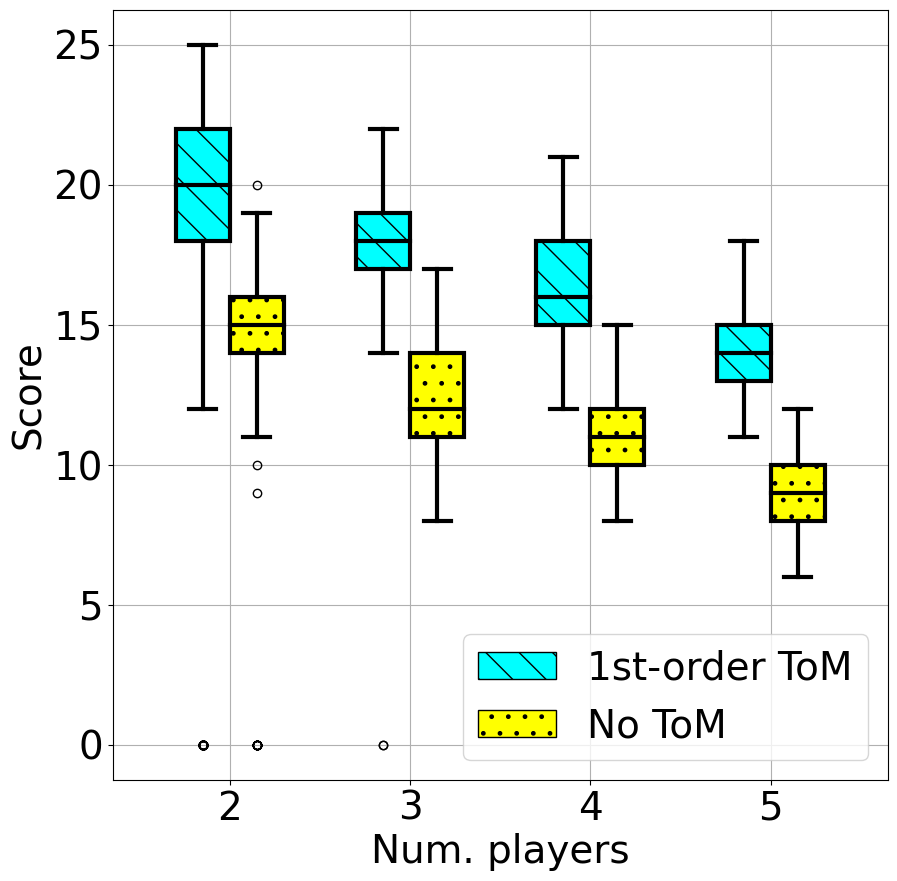

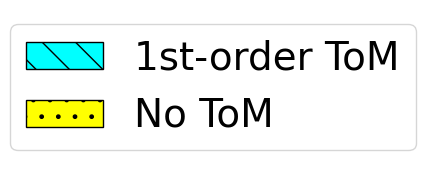

In [66]:
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')

epsilon = 0.15
lw = 3
colors = {True: 'aqua', False: 'yellow'}
texture = {True: '\\', False: '.'}
labs = {True: '1st-order ToM', False: 'No ToM'}

for n in player_configs:
    for abd in (True, False):
        if abd:
            x = n-epsilon
        else:
            x = n+epsilon
        data = results[abd][n]["score"].to_numpy()
        bp = ax.boxplot(
            data,
            positions=[x],
            widths=[epsilon*2],
            boxprops={'linewidth': lw},
            medianprops={'linewidth': lw, 'color': 'black'},
            capprops={'linewidth': lw},
            whiskerprops={'linewidth': lw},
            patch_artist=True
        )
        for patch in bp['boxes']:
            patch.set(facecolor=colors[abd])
            patch.set(hatch=texture[abd])


ax.set_xticks(player_configs, labels=player_configs)
ax.grid()
ax.set_xlabel("Num. players")
ax.set_ylabel("Score")

legend_elements = [
    Patch(facecolor=colors[abd], hatch=texture[abd], edgecolor='black', label=labs[abd])
    for abd in (True, False)
]
ax.legend(handles=legend_elements, loc='lower right')
# plt.savefig("score.png")
# plt.show()

# export legend stand-alone figure
# fig_leg, ax_leg = plt.subplots(figsize=(5, 2))
# ax_leg.legend(handles=legend_elements, loc='center')
# ax_leg.axis('off')
# ax_leg.set_frame_on(False)
# fig_leg.savefig('legend.png')

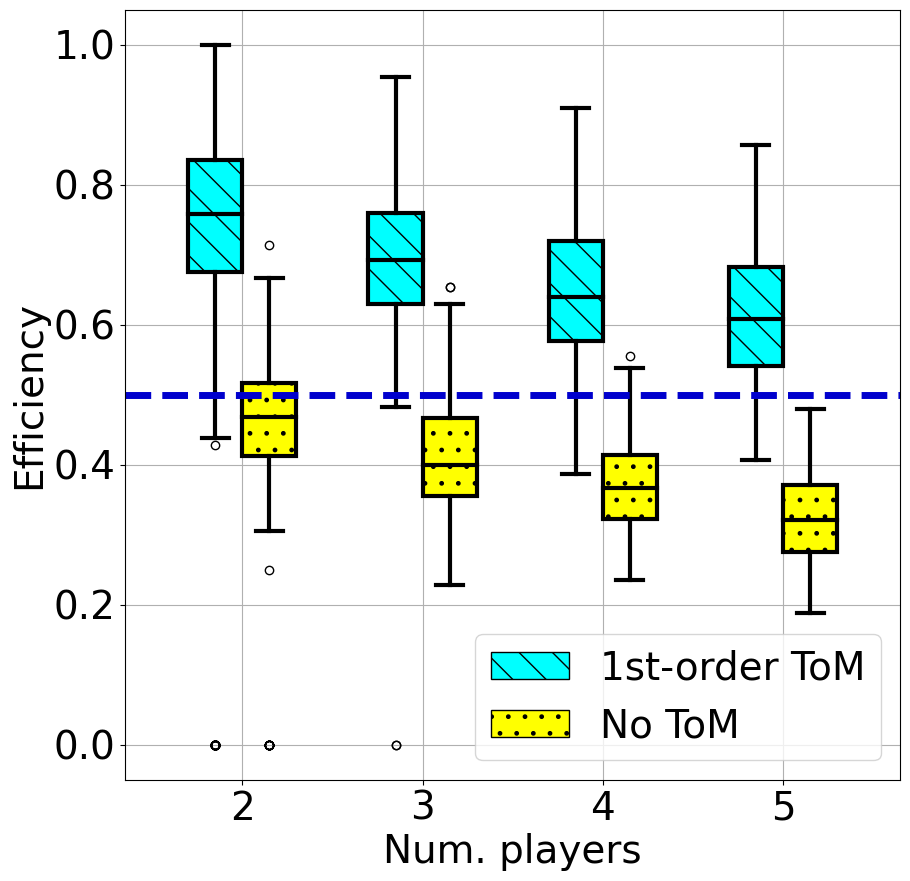

In [49]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')

for n in player_configs:
    for abd in (True, False):
        if abd:
            x = n-epsilon
        else:
            x = n+epsilon
        data = results[abd][n]["efficiency"].to_numpy()
        bp = ax.boxplot(
            data,
            positions=[x],
            widths=[epsilon*2],
            boxprops={'linewidth': lw},
            medianprops={'linewidth': lw, 'color': 'black'},
            capprops={'linewidth': lw},
            whiskerprops={'linewidth': lw},
            patch_artist=True
        )
        for patch in bp['boxes']:
            patch.set(facecolor=colors[abd])
            patch.set(hatch=texture[abd])

ax.set_xticks(player_configs, labels=player_configs)
ax.grid()
ax.set_xlabel("Num. players")
ax.set_ylabel("Efficiency")
ax.axhline(0.5, linewidth=5, color='mediumblue', linestyle='--')
ax.legend(handles=legend_elements, loc='lower right')
plt.savefig("efficiency.png")
plt.show()

## Average information per hint

In [7]:
for abd, n in product((True, False), player_configs):
    total_explicit_info = {}
    avg_explicit_info = {}
    if abd:
        total_implicit_info = {}
        avg_implicit_info = {}
        avg_explicit_distance = {}
        avg_implicit_distance = {}

    for seed in range(500):
        results_file = "{}/info_gain_{}_{}_{}.csv".format(path, str(abd).lower(), n, seed)
        df = pd.read_csv(results_file, sep=';')

        # compute information gain (relative to the pre-action distribution)
        # per move, aka the sum across all slots
        explicit_info_all_slots = df.groupby(["move"])["explicit_info"].sum().replace(0, np.NaN)
        total_explicit_info[seed] = explicit_info_all_slots.sum()
        avg_explicit_info[seed] = explicit_info_all_slots.mean()
        if abd:
            implicit_info_all_slots = df.groupby(["move"])["implicit_info"].sum().replace(0, np.NaN)
            total_implicit_info[seed] = implicit_info_all_slots.sum()
            avg_implicit_info[seed] = implicit_info_all_slots.mean()

    results[abd][n]["total_explicit_info"] = pd.Series(total_explicit_info)
    results[abd][n]["avg_explicit_info"] = pd.Series(avg_explicit_info)
    if abd:
        results[abd][n]["total_implicit_info"] = pd.Series(total_implicit_info)
        results[abd][n]["avg_implicit_info"] = pd.Series(avg_implicit_info)

## Score rate that can be assigned to explicit and implicit information

In [8]:
for n in player_configs:
    score = {}
    explicit_info = {}

    score_rate = {}

    results[False][n]["score_rate"] = results[False][n]["score"] / results[False][n]["total_explicit_info"]
    score_rate['explicit'] = results[False][n]["score_rate"].mean()

    results[True][n]["score_by_expl_info"] = results[True][n]["total_explicit_info"]*score_rate['explicit']
    results[True][n]["residual_score"] = results[True][n]["score"] - results[True][n]["score_by_expl_info"]

    results[True][n]["impl_score_rate"] = results[True][n]["residual_score"] / results[True][n]["total_implicit_info"]
    score_rate['implicit'] = results[True][n]["impl_score_rate"].replace([np.inf, -np.inf], np.nan).mean()

    print("{} players:".format(n))
    print("Explicit score rate: {:.2f}".format(score_rate['explicit']))
    print("Implicit score rate: {:.2f}".format(score_rate['implicit']))
    print("Ratio of implicit to explicit score rate: {:.1f}\n".format(score_rate['implicit']/score_rate['explicit']))

2 players:
Explicit score rate: 0.70
Implicit score rate: 1.18
Ratio of implicit to explicit score rate: 1.7

3 players:
Explicit score rate: 0.60
Implicit score rate: 1.50
Ratio of implicit to explicit score rate: 2.5

4 players:
Explicit score rate: 0.61
Implicit score rate: 1.32
Ratio of implicit to explicit score rate: 2.2

5 players:
Explicit score rate: 0.52
Implicit score rate: 1.42
Ratio of implicit to explicit score rate: 2.7



## Percentage of score that can be assigned to each type of information

In [9]:
for n in player_configs:
    score_by_expl_info = results[True][n]["total_explicit_info"]*results[False][n]["score_rate"]
    residual_score = results[True][n]["score"] - score_by_expl_info
    # residual_score = results[True][n]["score"] - results[False][n]["score"]
    percentage_impl_info = results[True][n]["total_implicit_info"] / (results[True][n]["total_implicit_info"] + results[True][n]["total_explicit_info"]) * 100
    percentage_impl_score = residual_score / results[True][n]["score"] * 100
    df = pd.DataFrame({'info': percentage_impl_info, 'score': percentage_impl_score})
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    print("{} players:".format(n))
    print(df.describe().loc["mean"])
    print()

2 players:
info    15.15
score   27.80
Name: mean, dtype: float64

3 players:
info    15.51
score   30.55
Name: mean, dtype: float64

4 players:
info    18.79
score   32.24
Name: mean, dtype: float64

5 players:
info    19.40
score   38.37
Name: mean, dtype: float64



## Statistical tests

Perform statistical tests to compare the performance metrics (score and 
efficiency) between the case when abduction is _off_ and _on_.

In [ ]:
plt.rcParams.update({'font.size': 24})

def plot_histogram(n, variable):
    fig, ax = plt.subplots(figsize=(8, 7.5), facecolor="white")
    if variable == "score":
        bins = range(0, 26)
    elif variable == "efficiency":
        bins = np.linspace(0, 1, 25)
    for abd in (True, False):
        x = results[abd][n][variable]
        ax.hist(x, bins, fc=colors[abd], ec="black", hatch=texture[abd])
    locs, labels = plt.yticks()
    labs = ["{:.2f}".format(i/500) for i in locs]
    ax.set_yticks(locs, labels=labs)
    if variable == "score":
        ax.set_xticks([0, 5, 10, 15, 20, 25])
    elif variable == "efficiency":
        ax.set_xticks([0., 0.25, 0.5, 0.75, 1.])
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel("Frequency")
    plt.savefig("hist_{}_{}.png".format(n, variable), bbox_inches='tight')
    # plt.show()

variables = ["score", "efficiency"]
for n, var in product(player_configs, variables):
    plot_histogram(n, var)

In [11]:
from scipy import stats

# Step 1: Check that the variables are normally distributed
variables = ["score", "efficiency"]
for n, abd, var in product(player_configs, (True, False), variables):
    x = results[abd][n][var]
    _, pvalue = stats.shapiro(x)
    print("{} players, abduction {}, {}: {:.2e}".format(n, abd, var, pvalue))

2 players, abduction True, score: 1.16e-31
2 players, abduction True, efficiency: 1.62e-28
2 players, abduction False, score: 5.68e-29
2 players, abduction False, efficiency: 7.97e-23
3 players, abduction True, score: 7.00e-25
3 players, abduction True, efficiency: 5.36e-15
3 players, abduction False, score: 4.60e-10
3 players, abduction False, efficiency: 2.84e-06
4 players, abduction True, score: 5.66e-10
4 players, abduction True, efficiency: 1.38e-02
4 players, abduction False, score: 6.47e-12
4 players, abduction False, efficiency: 1.18e-07
5 players, abduction True, score: 1.41e-11
5 players, abduction True, efficiency: 1.50e-04
5 players, abduction False, score: 3.37e-13
5 players, abduction False, efficiency: 2.36e-10


In [12]:
# Step 2: Pair-wise t-test
for n, var in product(player_configs, variables):
    x1 = results[True][n][var]
    x2 = results[False][n][var]
    _, pvalue = stats.ttest_rel(x1, x2)
    print("{} players, {}: {:.2e}".format(n, var, pvalue))

2 players, score: 2.62e-35
2 players, efficiency: 9.75e-72
3 players, score: 1.97e-194
3 players, efficiency: 6.26e-201
4 players, score: 1.09e-223
4 players, efficiency: 2.56e-217
5 players, score: 4.45e-232
5 players, efficiency: 3.80e-230


## Compare distances to the _true_ values

For every hint, find the _focus_ slot (if there is one). Then, compare the
distance of the probability distribution at the focus slot between the
**post-action** distribution and the **post-explanation**

In [13]:
distance_red = {p: [] for p in player_configs}

for n, seed in product(player_configs, range(500)):
    results_file = "{}/info_gain_true_{}_{}.csv".format(path, n, seed)
    df = pd.read_csv(results_file, sep=';')
    df["delta"] = df["distance_explicit"] - df["distance_implicit"]
    df_focus = df.loc[df["delta"] > 0.]
    percentage_reduction = (df_focus["distance_explicit"] - df_focus["distance_implicit"]) / df_focus["distance_explicit"] * 100
    distance_red[n].append(percentage_reduction.mean())

In [14]:
print("Percentage gain in distance to the ground truth:")
for p in player_configs:
    print("{} players: {:.2f}%".format(p, np.nanmean(distance_red[p])))

Percentage gain in distance to the ground truth:
2 players: 85.33%
3 players: 88.29%
4 players: 89.43%
5 players: 91.49%


# Elapsed Time of <span style="font-variant:small-caps;">TomAbductionTask</span>

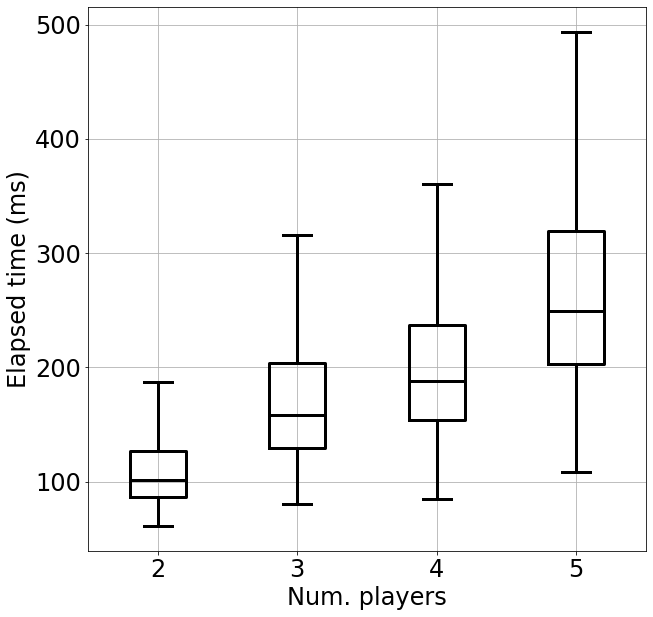

In [18]:
et_path = "/home/nmontes/Documentos/hanabi-results/elapsed-time"

data = []
for n in player_configs:
    et_df = pd.read_csv("{}/et_{}_players.csv".format(et_path, n), sep=';', names=['num_literals', 'et_us'])
    et_df['et_ms'] = et_df['et_us'] / 1000
    data.append(et_df['et_ms'].tolist())

fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
lw = 3
width = 0.40
bp = ax.boxplot(
    data,
    positions=player_configs,
    widths=[width]*len(player_configs),
    boxprops={'linewidth': lw},
    medianprops={'linewidth': lw, 'color': 'black'},
    capprops={'linewidth': lw},
    whiskerprops={'linewidth': lw},
    showfliers=False
)

ax.set_xticks(player_configs, labels=player_configs)
ax.grid()
ax.set_xlabel("Num. players")
ax.set_ylabel("Elapsed time (ms)")
# plt.savefig("elapsed_time.png", dpi=400)
plt.show()

